In [ ]:
import keras as keras
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
assert tf.__version__ >= "2.0"
import numpy as np
import os
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, callbacks
import pandas as pd
import cv2
import matplotlib
from keras.datasets import mnist, fashion_mnist
from keras.utils import np_utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, MaxPooling2D, Conv2D
import tensorflow_datasets as tfds
from sklearn.cluster import KMeans

Using TensorFlow backend.
/Users/jihaolin/opt/anaconda3/envs/tf/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
file_dir = '/Users/jihaolin/Desktop/2022spring/Machine Learning/XN/'

labels = pd.read_csv(file_dir + 'hemorrhage-labels.csv')
labels['sum'] = labels[['epidural','intraparenchymal','intraventricular','subarachnoid','subdural']].sum(axis=1)
labels = labels.drop(labels[labels['Image'] == 'ID_882cd57de'].index)#This pic's size is 490 × 638 which unusual
labels = labels.drop(labels[(labels['Image'] == 'ID_6431af929') &
                            (labels['Image'] == '20440abc6') &
                            (labels['Image'] == '1811d9bf2') &
                            (labels['Image'] == '75a698178') &
                            (labels['Image'] == '30010d605') &
                            (labels['Image'] == '34b04fff9') &
                            (labels['Image'] == '432bad415') &
                            (labels['Image'] == '3cb85bfca') &
                            (labels['Image'] == '4dad8b080')].index)#Those pic file is broken


In [ ]:
labels

,Image,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,sum
0,ID_000012eaf,0,0,0,0,0,0,0
1,ID_000039fa0,0,0,0,0,0,0,0
2,ID_00005679d,0,0,0,0,0,0,0
3,ID_00008ce3c,0,0,0,0,0,0,0
4,ID_0000950d7,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
752798,ID_ffff82e46,0,0,0,0,0,0,0
752799,ID_ffff922b9,1,0,0,1,0,0,1
752800,ID_ffffb670a,1,0,0,0,1,0,1
752801,ID_ffffcbff8,0,0,0,0,0,0,0


In [ ]:
filename = (['brain_bone_window','brain_window','max_contrast_window','subdural_window'])

case = labels.drop(labels[labels['any'] == 0].index)

epidural = case.drop(case[(case['epidural'] == 0) | (case['sum'] != 1)].index)
epi = epidural.Image#1
intraparenchymal = case.drop(case[(case['intraparenchymal'] == 0) | (case['sum'] != 1)].index)
intrap = intraparenchymal.Image#2
intraventricular = case.drop(case[(case['intraventricular'] == 0) | (case['sum'] != 1)].index)
intrav = intraventricular.Image#3
subarachnoid = case.drop(case[(case['subarachnoid'] == 0) | (case['sum'] != 1)].index)
suba = subarachnoid.Image#4
subdural = case.drop(case[(case['subdural'] == 0) | (case['sum'] != 1)].index)
subd = subdural.Image#5
normal = labels.drop(labels[labels['any'] == 1].index)
nor = normal.Image#6

In [ ]:
case

,Image,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,sum
14,ID_0002081b6,1,0,1,0,0,0,1
24,ID_0002a38ad,1,0,0,0,1,1,2
33,ID_000346ce2,1,0,0,0,0,1,1
36,ID_00042829c,1,0,0,1,0,0,1
43,ID_0004a5701,1,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...
752755,ID_fffc60817,1,0,1,1,0,0,2
752769,ID_fffd00949,1,0,0,0,1,0,1
752783,ID_fffe2edb8,1,0,1,1,0,0,2
752799,ID_ffff922b9,1,0,0,1,0,0,1


In [ ]:
Test_Size = 500

epidural_random = epidural.sample(n=Test_Size,replace=False,random_state=150)
epi_random = epidural_random.Image
intraparenchymal_random = intraparenchymal.sample(n=Test_Size,replace=False,random_state=150)
intrap_random = intraparenchymal_random.Image
intraventricular_random = intraventricular.sample(n=Test_Size,replace=False,random_state=150)
intrav_random = intraventricular_random.Image
subarachnoid_random = subarachnoid.sample(n=Test_Size,replace=False,random_state=150)
suba_random = subarachnoid_random.Image
subdural_random = subdural.sample(n=Test_Size,replace=False,random_state=150)
subd_random = subdural_random.Image
normal_random = normal.head(500)
nor_random = normal_random.Image

## 1. Import the datasets of four images

###  (1) [ epidural ]

In [ ]:
x_epi_1 = np.zeros([500, 262144])
y_epi = np.zeros(500)
for i, file in enumerate(epidural_random.Image):
    x_epi_1[i,:] = np.mean(matplotlib.image.imread(file_dir + 'epidural/' + filename[0] + '/' + file + '.jpg'),axis=2).reshape(-1)
x_epi_2 = np.zeros([500, 262144])
for i, file in enumerate(epidural_random.Image):
    x_epi_2[i,:] = np.mean(matplotlib.image.imread(file_dir + 'epidural/' + filename[1] + '/' + file + '.jpg'),axis=2).reshape(-1)
x_epi_3 = np.zeros([500, 262144])
for i, file in enumerate(epidural_random.Image):
    x_epi_3[i,:] = np.mean(matplotlib.image.imread(file_dir + 'epidural/' + filename[2] + '/' + file + '.jpg'),axis=2).reshape(-1)
x_epi_4 = np.zeros([500, 262144])
for i, file in enumerate(epidural_random.Image):
    x_epi_4[i,:] = np.mean(matplotlib.image.imread(file_dir + 'epidural/' + filename[3] + '/' + file + '.jpg'),axis=2).reshape(-1)

In [ ]:
x_epi = np.add(-3*x_epi_1,3*x_epi_2)
x_epi = np.add(x_epi,5*x_epi_3)
x_epi = np.add(x_epi,-4*x_epi_4)
x_epi = x_epi/4
x_epi.shape

(500, 262144)

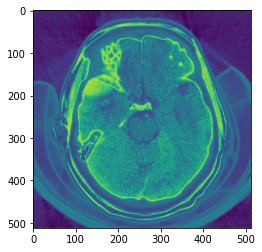

In [ ]:
plt.imshow(x_epi[36].reshape(512,512))  #a -2 1 2 -1

### (2)  [ intraparenchymal ]

In [ ]:
x_intrap_1 = np.zeros([500, 262144])
y_intrap = np.ones(500)
for i, file in enumerate(intraparenchymal_random.Image):
    x_intrap_1[i,:] = np.mean(matplotlib.image.imread(file_dir + 'intraparenchymal/' + filename[0] + '/' + file + '.jpg'),axis=2).reshape(-1)
x_intrap_2 = np.zeros([500, 262144])
for i, file in enumerate(intraparenchymal_random.Image):
    x_intrap_2[i,:] = np.mean(matplotlib.image.imread(file_dir + 'intraparenchymal/' + filename[1] + '/' + file + '.jpg'),axis=2).reshape(-1)
x_intrap_3 = np.zeros([500, 262144])
for i, file in enumerate(intraparenchymal_random.Image):
    x_intrap_3[i,:] = np.mean(matplotlib.image.imread(file_dir + 'intraparenchymal/' + filename[2] + '/' + file + '.jpg'),axis=2).reshape(-1)
x_intrap_4 = np.zeros([500, 262144])
for i, file in enumerate(intraparenchymal_random.Image):
    x_intrap_4[i,:] = np.mean(matplotlib.image.imread(file_dir + 'intraparenchymal/' + filename[3] + '/' + file + '.jpg'),axis=2).reshape(-1)

In [ ]:
x_intrap = np.add(-3*x_intrap_1,3*x_intrap_2)
x_intrap = np.add(x_intrap,5*x_intrap_3)
x_intrap = np.add(x_intrap,-4*x_intrap_4)
x_intrap = x_intrap/4
x_intrap.shape

(500, 262144)

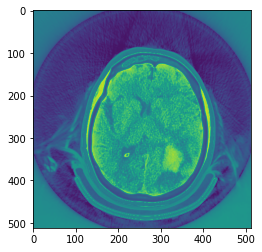

In [ ]:
plt.imshow(x_intrap[32].reshape(512,512))  #

### (3)  [ intraventricular ]

In [ ]:
x_intrav_1 = np.zeros([500, 262144])
y_intrav = np.full(500,2,dtype=int)
for i, file in enumerate(intraventricular_random.Image):
    x_intrav_1[i,:] = np.mean(matplotlib.image.imread(file_dir + 'intraventricular/' + filename[0] + '/' + file + '.jpg'),axis=2).reshape(-1)
x_intrav_2 = np.zeros([500, 262144])
for i, file in enumerate(intraventricular_random.Image):
    x_intrav_2[i,:] = np.mean(matplotlib.image.imread(file_dir + 'intraventricular/' + filename[1] + '/' + file + '.jpg'),axis=2).reshape(-1)
x_intrav_3 = np.zeros([500, 262144])
for i, file in enumerate(intraventricular_random.Image):
    x_intrav_3[i,:] = np.mean(matplotlib.image.imread(file_dir + 'intraventricular/' + filename[2] + '/' + file + '.jpg'),axis=2).reshape(-1)
x_intrav_4 = np.zeros([500, 262144])
for i, file in enumerate(intraventricular_random.Image):
    x_intrav_4[i,:] = np.mean(matplotlib.image.imread(file_dir + 'intraventricular/' + filename[3] + '/' + file + '.jpg'),axis=2).reshape(-1)

In [ ]:
x_intrav = np.add(-3*x_intrav_1,3*x_intrav_2)
x_intrav = np.add(x_intrav,5*x_intrav_3)
x_intrav = np.add(x_intrav,-4*x_intrav_4)
x_intrav = x_intrav/4
x_intrav.shape

(500, 262144)

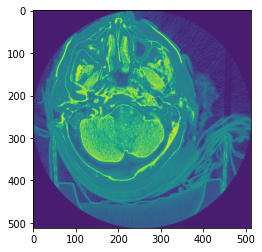

In [ ]:
plt.imshow(x_intrav[32].reshape(512,512))  #

### (4)  [ subarachnoid ]

In [ ]:
x_suba_1 = np.zeros([500, 262144])
y_suba = np.full(500,3,dtype=int)
for i, file in enumerate(subarachnoid_random.Image):
    x_suba_1[i,:] = np.mean(matplotlib.image.imread(file_dir + 'subarachnoid/' + filename[0] + '/' + file + '.jpg'),axis=2).reshape(-1)
x_suba_2 = np.zeros([500, 262144])
for i, file in enumerate(subarachnoid_random.Image):
    x_suba_2[i,:] = np.mean(matplotlib.image.imread(file_dir + 'subarachnoid/' + filename[1] + '/' + file + '.jpg'),axis=2).reshape(-1)
x_suba_3 = np.zeros([500, 262144])
for i, file in enumerate(subarachnoid_random.Image):
    x_suba_3[i,:] = np.mean(matplotlib.image.imread(file_dir + 'subarachnoid/' + filename[2] + '/' + file + '.jpg'),axis=2).reshape(-1)
x_suba_4 = np.zeros([500, 262144])
for i, file in enumerate(subarachnoid_random.Image):
    x_suba_4[i,:] = np.mean(matplotlib.image.imread(file_dir + 'subarachnoid/' + filename[3] + '/' + file + '.jpg'),axis=2).reshape(-1)

In [ ]:
x_suba = np.add(-3*x_suba_1,3*x_suba_2)
x_suba = np.add(x_suba,5*x_suba_3)
x_suba = np.add(x_suba,-4*x_suba_4)
x_suba = x_suba/4
x_suba.shape

(500, 262144)

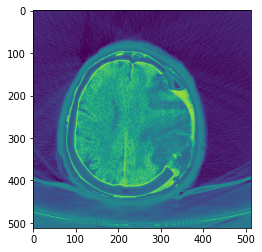

In [ ]:
plt.imshow(x_suba[32].reshape(512,512))  #

### (5)  [ subdural ]

In [ ]:
x_subd_1 = np.zeros([500, 262144])
y_subd = np.full(500,4,dtype=int)
for i, file in enumerate(subdural_random.Image):
    x_subd_1[i,:] = np.mean(matplotlib.image.imread(file_dir + 'subdural/' + filename[0] + '/' + file + '.jpg'),axis=2).reshape(-1)
x_subd_2 = np.zeros([500, 262144])
for i, file in enumerate(subdural_random.Image):
    x_subd_2[i,:] = np.mean(matplotlib.image.imread(file_dir + 'subdural/' + filename[1] + '/' + file + '.jpg'),axis=2).reshape(-1)
x_subd_3 = np.zeros([500, 262144])
for i, file in enumerate(subdural_random.Image):
    x_subd_3[i,:] = np.mean(matplotlib.image.imread(file_dir + 'subdural/' + filename[2] + '/' + file + '.jpg'),axis=2).reshape(-1)
x_subd_4 = np.zeros([500, 262144])
for i, file in enumerate(subdural_random.Image):
    x_subd_4[i,:] = np.mean(matplotlib.image.imread(file_dir + 'subdural/' + filename[3] + '/' + file + '.jpg'),axis=2).reshape(-1)

In [ ]:
x_subd = np.add(-3*x_subd_1,3*x_subd_2)
x_subd = np.add(x_subd,5*x_subd_3)
x_subd = np.add(x_subd,-4*x_subd_4)
x_subd = x_subd/4
x_subd.shape

(500, 262144)

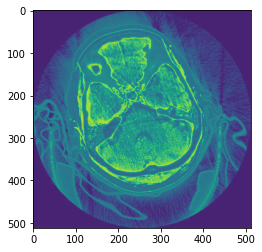

In [ ]:
plt.imshow(x_subd[32].reshape(512,512))  #

### (6)  [ normal ]

In [ ]:
x_nor_1 = np.zeros([500, 262144])
y_nor = np.full(500,5,dtype=int)
for i, file in enumerate(normal_random.Image):
    x_nor_1[i,:] = np.mean(matplotlib.image.imread(file_dir + 'normal/' + filename[0] + '/' + file + '.jpg'),axis=2).reshape(-1)
x_nor_2 = np.zeros([500, 262144])
for i, file in enumerate(normal_random.Image):
    x_nor_2[i,:] = np.mean(matplotlib.image.imread(file_dir + 'normal/' + filename[1] + '/' + file + '.jpg'),axis=2).reshape(-1)
x_nor_3 = np.zeros([500, 262144])
for i, file in enumerate(normal_random.Image):
    x_nor_3[i,:] = np.mean(matplotlib.image.imread(file_dir + 'normal/' + filename[2] + '/' + file + '.jpg'),axis=2).reshape(-1)
x_nor_4 = np.zeros([500, 262144])
for i, file in enumerate(normal_random.Image):
    x_nor_4[i,:] = np.mean(matplotlib.image.imread(file_dir + 'normal/' + filename[3] + '/' + file + '.jpg'),axis=2).reshape(-1)

In [ ]:
x_nor = np.add(-3*x_nor_1,4*x_nor_2)
x_nor = np.add(x_nor,5*x_nor_3)
x_nor = np.add(x_nor,-4*x_nor_4)
x_nor = x_nor/4
x_nor.shape

(500, 262144)

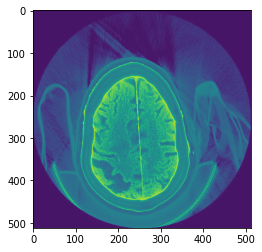

In [ ]:
plt.imshow(x_nor[36].reshape(512,512))

## 2. Scale down the image scale

###  (1) [ epidural ]

In [ ]:
DS = 4            # Down scale rate, must be a multiple of 262144
ds = 2

N = 500  # The length of the training data

if 262144/DS % 1 > 0:
    print("Downsample rate is not a multiple of 30976")
    DS = 1
    im_size = 262144
else:
    im_size = int(262144/DS)
im_size

65536

In [ ]:
x_epi_Sd = np.zeros([N, im_size*ds])
y_epi_Sd = np.zeros([N])

for n in range(N):
    for i in range(ds):
        x_epi_Sd[n,:] = x_epi[n,i::ds]
        y_epi_Sd[n] = y_epi[n]

x_epi_sd = np.zeros([N, 256, 256])
y_epi_sd = np.zeros([N])
x_epi_Sd = x_epi_Sd.reshape(-1,512,256)

for n in range(N):
    for i in range(ds):
        x_epi_sd[n,:,:] = x_epi_Sd[n,i::ds,:]
        kmeans = KMeans(n_clusters=32, random_state=0).fit(x_epi_sd[n,:])
        x_epi_sd[n,:] = kmeans.cluster_centers_[kmeans.labels_]
        y_epi_sd[n] = y_epi[n]
x_epi_sd = x_epi_sd.reshape(-1,256*256)
print(x_epi_sd.shape,y_epi_sd.shape)

(500, 65536) (500,)


In [ ]:
plt.imshow(x_epi_sd[36].reshape(256,256))

### (2)  [ intraparenchymal ]

In [ ]:
x_intrap_Sd = np.zeros([N, im_size*ds])
y_intrap_Sd = np.zeros([N])

for n in range(N):
    for i in range(ds):
        x_intrap_Sd[n,:] = x_intrap[n,i::ds]
        x_intrap_Sd[n] = x_intrap_Sd[n]

x_intrap_sd = np.zeros([N, 256, 256])
y_intrap_sd = np.zeros([N])
x_intrap_Sd = x_intrap_Sd.reshape(-1,512,256)

for n in range(N):
    for i in range(ds):
        x_intrap_sd[n,:,:] = x_intrap_Sd[n,i::ds,:]
        kmeans = KMeans(n_clusters=10, random_state=0).fit(x_intrap_sd[n,:])
        x_intrap_sd[n,:] = kmeans.cluster_centers_[kmeans.labels_]
        y_intrap_sd[n] = y_intrap[n]
x_intrap_sd = x_intrap_sd.reshape(-1,256*256)
print(x_intrap_sd.shape,y_intrap_sd.shape)

(500, 65536) (500,)


### (3)  [ intraventricular ]

In [ ]:
x_intrav_Sd = np.zeros([N, im_size*ds])
y_intrav_Sd = np.zeros([N])

for n in range(N):
    for i in range(ds):
        x_intrav_Sd[n,:] = x_intrav[n,i::ds]
        x_intrav_Sd[n] = x_intrav_Sd[n]

x_intrav_sd = np.zeros([N, 256, 256])
y_intrav_sd = np.zeros([N])
x_intrav_Sd = x_intrav_Sd.reshape(-1,512,256)

for n in range(N):
    for i in range(ds):
        x_intrav_sd[n,:,:] = x_intrav_Sd[n,i::ds,:]
        kmeans = KMeans(n_clusters=10, random_state=0).fit(x_intrav_sd[n,:])
        x_intrav_sd[n,:] = kmeans.cluster_centers_[kmeans.labels_]
        y_intrav_sd[n] = y_intrav[n]
x_intrav_sd = x_intrav_sd.reshape(-1,256*256)
print(x_intrav_sd.shape,y_intrav_sd.shape)

(500, 65536) (500,)


### (4)  [ subarachnoid ]

In [ ]:
x_suba_Sd = np.zeros([N, im_size*ds])
y_suba_Sd = np.zeros([N])

for n in range(N):
    for i in range(ds):
        x_suba_Sd[n,:] = x_suba[n,i::ds]
        x_suba_Sd[n] = x_suba_Sd[n]

x_suba_sd = np.zeros([N, 256, 256])
y_suba_sd = np.zeros([N])
x_suba_Sd = x_suba_Sd.reshape(-1,512,256)

for n in range(N):
    for i in range(ds):
        x_suba_sd[n,:,:] = x_suba_Sd[n,i::ds,:]
        kmeans = KMeans(n_clusters=10, random_state=0).fit(x_suba_sd[n,:])
        x_suba_sd[n,:] = kmeans.cluster_centers_[kmeans.labels_]
        y_suba_sd[n] = y_suba[n]
x_suba_sd = x_suba_sd.reshape(-1,256*256)
print(x_suba_sd.shape,y_suba_sd.shape)

(500, 65536) (500,)


### (5)  [ subdural ]

In [ ]:
x_subd_Sd = np.zeros([N, im_size*ds])
y_subd_Sd = np.zeros([N])

for n in range(N):
    for i in range(ds):
        x_subd_Sd[n,:] = x_subd[n,i::ds]
        x_subd_Sd[n] = x_subd_Sd[n]

x_subd_sd = np.zeros([N, 256, 256])
y_subd_sd = np.zeros([N])
x_subd_Sd = x_suba_Sd.reshape(-1,512,256)

for n in range(N):
    for i in range(ds):
        x_subd_sd[n,:,:] = x_subd_Sd[n,i::ds,:]
        kmeans = KMeans(n_clusters=10, random_state=0).fit(x_subd_sd[n,:])
        x_subd_sd[n,:] = kmeans.cluster_centers_[kmeans.labels_]
        y_subd_sd[n] = y_subd[n]
x_subd_sd = x_subd_sd.reshape(-1,256*256)
print(x_subd_sd.shape,y_subd_sd.shape)

(500, 65536) (500,)


### (6)  [ normal ]

In [ ]:
x_nor_Sd = np.zeros([N, im_size*ds])
y_nor_Sd = np.zeros([N])

for n in range(N):
    for i in range(ds):
        x_nor_Sd[n,:] = x_nor[n,i::ds]
        x_nor_Sd[n] = x_nor_Sd[n]

x_nor_sd = np.zeros([N, 256, 256])
y_nor_sd = np.zeros([N])
x_nor_Sd = x_nor_Sd.reshape(-1,512,256)

for n in range(N):
    for i in range(ds):
        x_nor_sd[n,:,:] = x_nor_Sd[n,i::ds,:]
        kmeans = KMeans(n_clusters=10, random_state=0).fit(x_nor_sd[n,:])
        x_nor_sd[n,:] = kmeans.cluster_centers_[kmeans.labels_]
        y_nor_sd[n] = y_nor[n]
x_nor_sd = x_nor_sd.reshape(-1,256*256)
print(x_nor_sd.shape,y_nor_sd.shape)

(500, 65536) (500,)


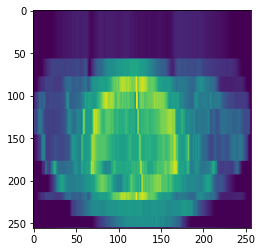

In [ ]:
plt.imshow(x_nor_sd[36].reshape(256,256))

## 3. Now classify normal and case

In [ ]:
num = 200
X = np.vstack((x_epi_sd[:num],x_intrap_sd[:num]))
X = np.vstack((X,x_intrav_sd[:num]))
X = np.vstack((X,x_suba_sd[:num]))
X = np.vstack((X,x_subd_sd[:num]))
X = np.vstack((X,x_nor_sd[:num]))
X.shape

(1200, 65536)

In [ ]:
Y = np.hstack((y_epi[:num],y_intrap[:num]))
Y = np.hstack((Y,y_intrav[:num]))
Y = np.hstack((Y,y_suba[:num]))
Y = np.hstack((Y,y_subd[:num]))
Y = np.hstack((Y,y_nor[:num]))
Y.shape

(1200,)

In [ ]:
tr = .8
tr2 = .2
tc = int(tr * len(X))
np.random.seed(100)
np.random.shuffle(X)
np.random.seed(100)
np.random.shuffle(Y)
x_train = X[:tc]
y_train = Y[:tc]
x_test = X[tc:]
y_test = Y[tc:]

In [ ]:
NUM_LABELS = 10

## Normalize training data to be between 0 and 1, we have to typecast it as a float to do so.
X_train = x_train.astype('float32')
X_test = x_test.astype('float32')
X_train /= 255
X_test /= 255

X_train = X_train.reshape(-1,int(X.shape[0]*X.shape[1]*tr))
X_test = X_test.reshape(-1,int(X.shape[0]*X.shape[1]*tr2))

# one-hot encoding:
Y_train = np_utils.to_categorical(y_train, NUM_LABELS)
Y_test = np_utils.to_categorical(y_test, NUM_LABELS)

print()
print('Data loaded: train:',len(x_train),'test:',len(x_test))
print('x_train:', x_train.shape)
print('X_train:', X_train.shape)
print('X_test:', X_test.shape)
print('y_train:', y_train.shape)
print('Y_train:', Y_train.shape)
print('Y_test:', Y_test.shape)


Data loaded: train: 960 test: 240
x_train: (960, 65536)
X_train: (1, 62914560)
X_test: (1, 15728640)
y_train: (960,)
Y_train: (960, 10)
Y_test: (240, 10)


In [ ]:
#(12,12)
#(7,7)

In [ ]:
model = Sequential()

model.add(Conv2D(32, (12,12),
                 padding='valid',
                 input_shape=(256,256,1),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, (7,7),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=NUM_LABELS, activation='softmax'))
optimizer = tf.keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 245, 245, 32)      4640      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 122, 122, 32)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 116, 116, 32)      50208     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 58, 58, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 58, 58, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 107648)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)              

In [ ]:
x_Train = X_train.reshape(-1, 256, 256, 1)
x_Test = x_test.reshape(-1, 256, 256, 1)

In [ ]:
epochs = 20

history = model.fit(x_Train,
                    Y_train,
                    epochs=epochs,
                    batch_size=240,
                    verbose=1,
                    validation_data=(x_Test, Y_test))

Train on 960 samples, validate on 240 samples
Epoch 1/20
960/960 [==============================] - 222s 232ms/sample - loss: 9.7780 - accuracy: 0.1323 - val_loss: 7.3267 - val_accuracy: 0.2042
Epoch 2/20
960/960 [==============================] - 217s 226ms/sample - loss: 2.2079 - accuracy: 0.1552 - val_loss: 385.1853 - val_accuracy: 0.2042
Epoch 3/20
960/960 [==============================] - 216s 225ms/sample - loss: 2.5187 - accuracy: 0.1771 - val_loss: 167.4372 - val_accuracy: 0.1583
Epoch 4/20
960/960 [==============================] - 216s 225ms/sample - loss: 1.9270 - accuracy: 0.2271 - val_loss: 42.2223 - val_accuracy: 0.2083
Epoch 5/20
960/960 [==============================] - 216s 225ms/sample - loss: 1.8832 - accuracy: 0.2104 - val_loss: 93.7635 - val_accuracy: 0.2208
Epoch 6/20
960/960 [==============================] - 215s 223ms/sample - loss: 2.0357 - accuracy: 0.2104 - val_loss: 58.4015 - val_accuracy: 0.2208
Epoch 7/20
960/960 [==============================] - 214s 

In [ ]:
# plotting the metrics
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()

fig

In [ ]:
#(20,20)
#(7,7)

In [ ]:
model = Sequential()

model.add(Conv2D(32, (10,10),
                 padding='valid',
                 input_shape=(256,256,1),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Conv2D(32, (7,7),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=NUM_LABELS, activation='softmax'))
optimizer = tf.keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

print(model.summary())

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 247, 247, 32)      3232      
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 82, 82, 32)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 76, 76, 32)        50208     
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 38, 38, 32)        0         
_________________________________________________________________
dropout_40 (Dropout)         (None, 38, 38, 32)        0         
_________________________________________________________________
flatten_20 (Flatten)         (None, 46208)             0         
_________________________________________________________________
dense_40 (Dense)             (None, 128)             

In [ ]:
epochs = 20

history = model.fit(x_Train,
                    Y_train,
                    epochs=epochs,
                    batch_size=240,
                    verbose=1,
                    validation_data=(x_Test, Y_test))

Train on 960 samples, validate on 240 samples
Epoch 1/20
960/960 [==============================] - 138s 144ms/sample - loss: 4.8475 - accuracy: 0.1729 - val_loss: 355.8885 - val_accuracy: 0.1417
Epoch 2/20
960/960 [==============================] - 129s 135ms/sample - loss: 2.4676 - accuracy: 0.1698 - val_loss: 41.5902 - val_accuracy: 0.1750
Epoch 3/20
960/960 [==============================] - 128s 133ms/sample - loss: 2.7331 - accuracy: 0.1792 - val_loss: 118.8313 - val_accuracy: 0.1417
Epoch 4/20
960/960 [==============================] - 129s 135ms/sample - loss: 2.1464 - accuracy: 0.1979 - val_loss: 79.2898 - val_accuracy: 0.1583
Epoch 5/20
960/960 [==============================] - 130s 135ms/sample - loss: 1.9279 - accuracy: 0.2052 - val_loss: 48.4515 - val_accuracy: 0.2500
Epoch 6/20
960/960 [==============================] - 127s 132ms/sample - loss: 1.8989 - accuracy: 0.2104 - val_loss: 67.2450 - val_accuracy: 0.2292
Epoch 7/20
960/960 [==============================] - 129s

KeyboardInterrupt: 

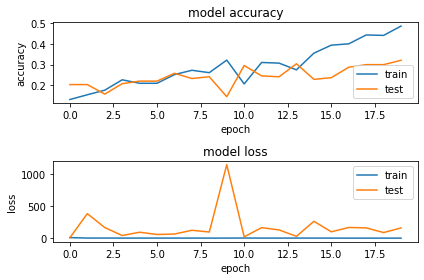

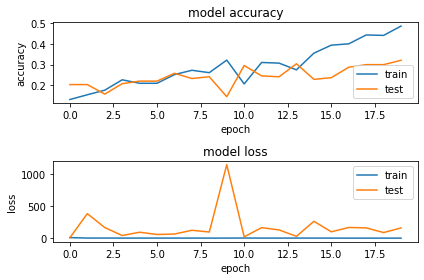

In [ ]:
# plotting the metrics
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()

fig